In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Pin versions that are known to work together
!pip install --upgrade pip
!pip install --upgrade "numpy<2.0" torch torchvision torchaudio
!pip install ultralytics==8.2.103

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 40.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 28.3 MB/s  0:00:15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 16.8 MB/s  0:00:19
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 134.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 70.6 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 59.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 76.1 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 68.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 76.1 MB/s  0:00:03
   ━━━━━━━━

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 8.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 52.0 MB/s  0:00:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ultralytics]


In [3]:
import os
import cv2
import random
import numpy as np
from ultralytics import YOLO
from collections import Counter
from matplotlib import pyplot as plt

prev_model_path = '/content/best3.pt'

plt.rcParams['figure.figsize'] = [15, 10]

folder = '/content/drive/MyDrive/datasets/dataset_drones_split'

images_root = os.path.join(folder, 'images')
labels_root = os.path.join(folder, 'labels')


In [4]:
# this should be run once

splits = ['train', 'val', 'test']

all_images = []

for split in splits:
    split_folder = os.path.join(images_root, split)
    for fname in os.listdir(split_folder):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            all_images.append({
                "path": os.path.join(split_folder, fname),
                "filename": fname,
                "split": split
            })

In [5]:

print(f'Total images: {len(all_images)}')
print(Counter([img['split'] for img in all_images]))


Total images: 4000
Counter({'train': 2799, 'val': 801, 'test': 400})


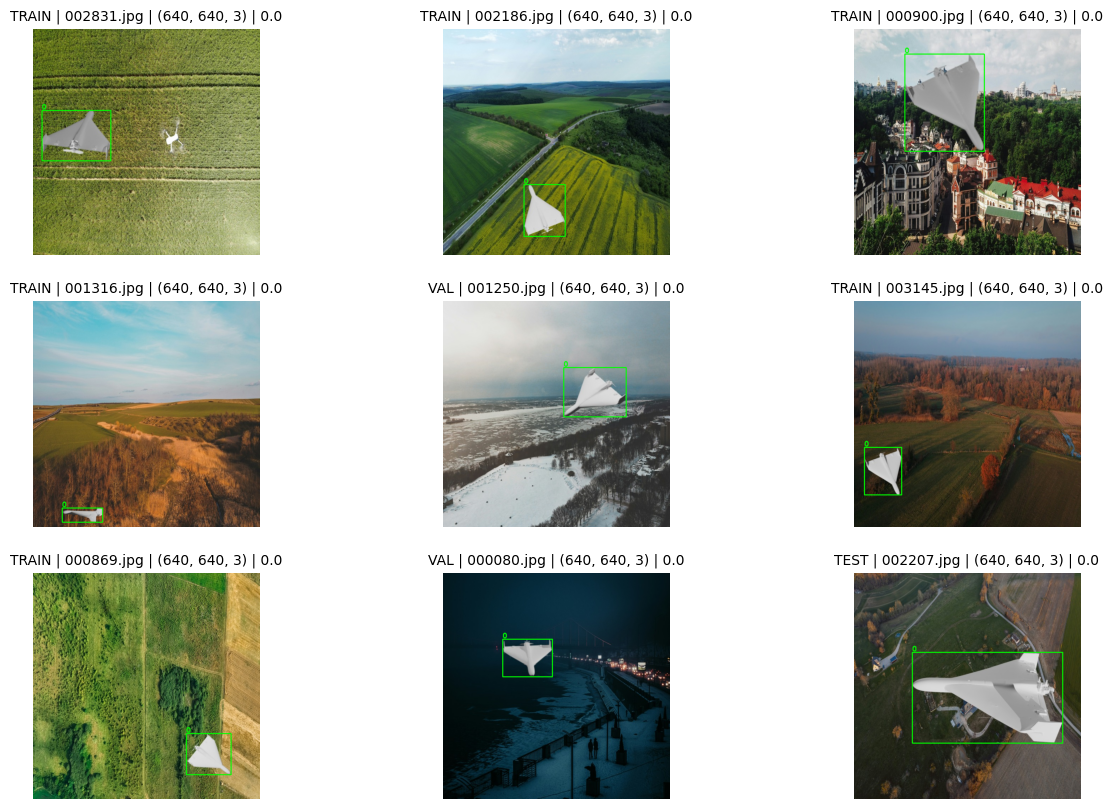

In [6]:
sampled = random.sample(all_images, 9)

for i, sample in enumerate(sampled):
    img_path = sample["path"]
    split = sample["split"]
    fname = sample["filename"]

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Label file corresponding to the split
    label_path = os.path.join(labels_root, split, fname.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Draw GT bounding boxes (YOLO format)
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x1 = int((x - bw/2) * w)
                y1 = int((y - bh/2) * h)
                x2 = int((x + bw/2) * w)
                y2 = int((y + bh/2) * h)

                # draw green GT box
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{int(cls)}", (x1, y1 - 4),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{split.upper()} | {fname} | {img.shape} | {cls}", fontsize=10)


In [7]:
base_model = YOLO(prev_model_path)  # load pretrained model
base_model.info()

Model summary: 225 layers, 11,135,987 parameters, 0 gradients, 28.6 GFLOPs


(225, 11135987, 0, 28.6469632)

In [8]:
!yolo settings wandb=False

JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [9]:
SAVE_DIR = "/content/drive/MyDrive/yolo_runs_shahed"
!mkdir -p {SAVE_DIR}

In [10]:
!ln -s /content/drive/MyDrive/yolo_runs_shahed /content/yolo_runs_shahed

In [17]:
from ultralytics import settings
settings.update({"wandb": False})

In [20]:
base_model.train(
    data="drones_desc.yaml",
    epochs=80,
    imgsz=640,
    batch=16,
    patience=20,
    name="drone_shahed",
    project="yolo_runs_shahed",
)

New https://pypi.org/project/ultralytics/8.3.249 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/best3.pt, data=drones_desc.yaml, epochs=80, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_runs_shahed, name=drone_shahed4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning /content/drive/MyDrive/datasets/dataset_drones_split/labels/train.cache... 2799 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2799/2799 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/datasets/dataset_drones_split/labels/val.cache... 800 images, 1 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to yolo_runs_shahed/drone_shahed4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolo_runs_shahed/drone_shahed4
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      4.33G     0.4807      0.373     0.9879         24        640: 100%|██████████| 175/175 [01:11<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]

                   all        801        800       0.99      0.987      0.994       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80       3.9G     0.4973     0.3933     0.9902         22        640: 100%|██████████| 175/175 [01:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]

                   all        801        800      0.991      0.996      0.994      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      3.91G     0.5317     0.4117       1.01         27        640: 100%|██████████| 175/175 [01:10<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]

                   all        801        800      0.992      0.988      0.994      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      3.88G     0.5374     0.4233      1.007         20        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.44it/s]

                   all        801        800      0.992      0.986      0.994      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      3.84G     0.5286     0.4083     0.9966         24        640: 100%|██████████| 175/175 [01:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.61it/s]

                   all        801        800      0.995      0.989      0.994      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      3.85G     0.5449     0.4065      1.008         21        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.48it/s]

                   all        801        800      0.995      0.992      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      3.87G     0.5279     0.3976          1         25        640: 100%|██████████| 175/175 [01:12<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]

                   all        801        800      0.992       0.99      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      3.88G     0.5114     0.3859     0.9883         22        640: 100%|██████████| 175/175 [01:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]

                   all        801        800      0.991      0.982      0.993      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      3.84G     0.4979     0.3806     0.9818         28        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]

                   all        801        800       0.99       0.99      0.994      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      3.88G     0.4848      0.377     0.9774         29        640: 100%|██████████| 175/175 [01:12<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.988      0.996      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      3.88G      0.488     0.3734     0.9726         18        640: 100%|██████████| 175/175 [01:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.27it/s]

                   all        801        800      0.992      0.991      0.994      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      3.88G     0.4835     0.3714     0.9705         31        640: 100%|██████████| 175/175 [01:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:09<00:00,  2.63it/s]

                   all        801        800      0.996      0.992      0.994      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      3.84G     0.4874     0.3705     0.9747         25        640: 100%|██████████| 175/175 [01:12<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.49it/s]

                   all        801        800      0.995      0.984      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      3.87G     0.4682     0.3579     0.9623         19        640: 100%|██████████| 175/175 [01:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.25it/s]

                   all        801        800      0.992      0.988      0.994      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      3.88G     0.4601     0.3518     0.9625         15        640: 100%|██████████| 175/175 [01:14<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.22it/s]

                   all        801        800      0.993      0.989      0.994      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      3.88G     0.4695     0.3563     0.9636         27        640: 100%|██████████| 175/175 [01:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]

                   all        801        800      0.992      0.995      0.994      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      3.84G     0.4653     0.3525     0.9646         30        640: 100%|██████████| 175/175 [01:14<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.53it/s]

                   all        801        800      0.994       0.99      0.994      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      3.87G     0.4659     0.3449     0.9648         23        640: 100%|██████████| 175/175 [01:14<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.41it/s]

                   all        801        800      0.993      0.993      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      3.88G     0.4564     0.3379     0.9626         21        640: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]

                   all        801        800      0.996      0.988      0.994      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      3.88G     0.4512     0.3361     0.9549         31        640: 100%|██████████| 175/175 [01:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]

                   all        801        800      0.993      0.993      0.994       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      3.84G     0.4352     0.3242     0.9517         22        640: 100%|██████████| 175/175 [01:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]

                   all        801        800      0.992      0.999      0.994      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      3.87G     0.4378     0.3243     0.9424         24        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]

                   all        801        800      0.992      0.991      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      3.86G     0.4362     0.3276     0.9445         26        640: 100%|██████████| 175/175 [01:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.23it/s]

                   all        801        800      0.997      0.994      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      3.88G     0.4285     0.3192     0.9436         27        640: 100%|██████████| 175/175 [01:14<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.51it/s]

                   all        801        800      0.994      0.996      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      3.84G     0.4144     0.3051     0.9254         23        640: 100%|██████████| 175/175 [01:14<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]

                   all        801        800      0.991      0.991      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      3.87G     0.4304     0.3151     0.9414         21        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.29it/s]

                   all        801        800      0.999      0.995      0.994      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      3.88G      0.423      0.311     0.9438         23        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.29it/s]

                   all        801        800      0.999      0.992      0.994      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      3.88G     0.4163     0.3139     0.9329         28        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]

                   all        801        800      0.996      0.994      0.994      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      3.84G     0.4169     0.3088      0.933         27        640: 100%|██████████| 175/175 [01:11<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]

                   all        801        800      0.996      0.995      0.994      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      3.86G     0.4141     0.3035     0.9356         20        640: 100%|██████████| 175/175 [01:10<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]

                   all        801        800      0.994      0.999      0.994      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      3.86G     0.4057     0.2936     0.9361         25        640: 100%|██████████| 175/175 [01:12<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.26it/s]

                   all        801        800      0.996      0.996      0.994      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      3.89G     0.4016     0.2946     0.9267         15        640: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.49it/s]

                   all        801        800      0.994      0.996      0.994      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      3.84G     0.3985      0.292     0.9309         26        640: 100%|██████████| 175/175 [01:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.48it/s]

                   all        801        800      0.996      0.995      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      3.86G      0.392     0.2915     0.9261         30        640: 100%|██████████| 175/175 [01:15<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]

                   all        801        800      0.996      0.995      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      3.86G     0.3951     0.2902     0.9277         25        640: 100%|██████████| 175/175 [01:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.20it/s]

                   all        801        800      0.996      0.996      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80       3.9G     0.3896     0.2827     0.9229         20        640: 100%|██████████| 175/175 [01:12<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]

                   all        801        800      0.997      0.995      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      3.84G     0.3812     0.2818     0.9222         25        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]

                   all        801        800      0.996      0.994      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      3.86G      0.384     0.2836     0.9168         33        640: 100%|██████████| 175/175 [01:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]

                   all        801        800      0.993      0.994      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      3.86G     0.3746     0.2733     0.9184         22        640: 100%|██████████| 175/175 [01:12<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.24it/s]

                   all        801        800      0.996      0.992      0.994      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      3.88G     0.3726     0.2744     0.9167         21        640: 100%|██████████| 175/175 [01:12<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]

                   all        801        800      0.997      0.995      0.994      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      3.83G     0.3803     0.2775     0.9195         23        640: 100%|██████████| 175/175 [01:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.53it/s]

                   all        801        800      0.996      0.996      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      3.86G     0.3762     0.2776     0.9253         23        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.49it/s]

                   all        801        800      0.998      0.994      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      3.85G     0.3587     0.2613     0.9083         27        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]

                   all        801        800      0.996      0.991      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      3.89G     0.3616     0.2656     0.9109         31        640: 100%|██████████| 175/175 [01:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.27it/s]

                   all        801        800      0.995      0.993      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      3.83G     0.3556     0.2583      0.909         18        640: 100%|██████████| 175/175 [01:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.25it/s]

                   all        801        800      0.998      0.994      0.994      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      3.86G      0.367     0.2663     0.9159         23        640: 100%|██████████| 175/175 [01:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.21it/s]

                   all        801        800      0.996      0.995      0.994      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      3.85G     0.3617     0.2598     0.9118         24        640: 100%|██████████| 175/175 [01:11<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.23it/s]

                   all        801        800      0.998      0.993      0.994      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      3.89G      0.352     0.2487     0.9093         26        640: 100%|██████████| 175/175 [01:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.996      0.997      0.994      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      3.84G     0.3565      0.258     0.9083         18        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]

                   all        801        800      0.999      0.995      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      3.86G     0.3409     0.2458     0.9002         27        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]

                   all        801        800      0.999      0.996      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      3.86G      0.345     0.2471     0.9036         21        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]

                   all        801        800      0.997      0.996      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      3.88G     0.3482     0.2492     0.9084         18        640: 100%|██████████| 175/175 [01:12<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.38it/s]

                   all        801        800      0.998      0.996      0.994      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      3.83G     0.3388     0.2448     0.9035         28        640: 100%|██████████| 175/175 [01:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.52it/s]

                   all        801        800      0.999      0.994      0.994      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      3.86G     0.3345     0.2454     0.8993         26        640: 100%|██████████| 175/175 [01:12<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.51it/s]

                   all        801        800      0.997      0.996      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      3.85G     0.3369     0.2458     0.8992         22        640: 100%|██████████| 175/175 [01:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.996      0.996      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      3.89G     0.3369     0.2474     0.9014         24        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]

                   all        801        800      0.997      0.996      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      3.83G     0.3334     0.2493      0.905         29        640: 100%|██████████| 175/175 [01:10<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.997      0.997      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      3.86G     0.3373     0.2448     0.8971         33        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.32it/s]

                   all        801        800      0.996      0.997      0.994      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      3.85G     0.3295     0.2393     0.9003         26        640: 100%|██████████| 175/175 [01:12<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.31it/s]

                   all        801        800      0.998      0.995      0.994      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      3.89G     0.3312     0.2405     0.8988         17        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.998      0.995      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      3.83G     0.3329     0.2422     0.8995         25        640: 100%|██████████| 175/175 [01:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]

                   all        801        800      0.996      0.996      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      3.86G     0.3169     0.2328     0.8887         24        640: 100%|██████████| 175/175 [01:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.29it/s]

                   all        801        800      0.999      0.996      0.994      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      3.85G     0.3134     0.2259     0.8886         31        640: 100%|██████████| 175/175 [01:11<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.34it/s]

                   all        801        800      0.996      0.996      0.994      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      3.89G     0.3148     0.2287       0.89         23        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.47it/s]

                   all        801        800      0.998      0.996      0.994      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      3.83G      0.314      0.226     0.8886         19        640: 100%|██████████| 175/175 [01:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]

                   all        801        800      0.999      0.996      0.994      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      3.86G     0.3121     0.2223     0.8856         26        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.42it/s]

                   all        801        800      0.999      0.993      0.994      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      3.85G     0.3119     0.2289       0.89         20        640: 100%|██████████| 175/175 [01:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]

                   all        801        800      0.997      0.996      0.994      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      3.89G      0.296     0.2159     0.8854         26        640: 100%|██████████| 175/175 [01:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.23it/s]

                   all        801        800      0.998      0.995      0.994      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      3.83G     0.3133     0.2217     0.8954         27        640: 100%|██████████| 175/175 [01:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.26it/s]

                   all        801        800      0.996      0.995      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      3.86G     0.3071     0.2201     0.8869         25        640: 100%|██████████| 175/175 [01:14<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.43it/s]

                   all        801        800      0.998      0.996      0.994      0.986


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      3.85G     0.2172     0.1549     0.8333         14        640: 100%|██████████| 175/175 [01:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.53it/s]

                   all        801        800      0.998      0.996      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      3.89G     0.2226     0.1576     0.8317         15        640: 100%|██████████| 175/175 [01:09<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.51it/s]

                   all        801        800      0.995      0.997      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      3.83G     0.2106     0.1503     0.8258         15        640: 100%|██████████| 175/175 [01:10<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.28it/s]

                   all        801        800      0.996      0.998      0.994      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      3.86G      0.211     0.1496     0.8277         15        640: 100%|██████████| 175/175 [01:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.997      0.997      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      3.85G     0.2052     0.1471     0.8283         15        640: 100%|██████████| 175/175 [01:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.29it/s]

                   all        801        800      0.996      0.997      0.994       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      3.89G     0.2047     0.1446     0.8288         15        640: 100%|██████████| 175/175 [01:10<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.29it/s]

                   all        801        800      0.997      0.997      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      3.83G     0.2044     0.1477     0.8251         15        640: 100%|██████████| 175/175 [01:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.997      0.997      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      3.86G     0.2047     0.1471     0.8258         15        640: 100%|██████████| 175/175 [01:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.35it/s]

                   all        801        800      0.997      0.997      0.994       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      3.85G     0.1963     0.1421     0.8216         15        640: 100%|██████████| 175/175 [01:09<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.33it/s]

                   all        801        800      0.997      0.996      0.994       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      3.89G     0.2005     0.1461     0.8215         14        640: 100%|██████████| 175/175 [01:09<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:11<00:00,  2.30it/s]

                   all        801        800      0.996      0.996      0.994      0.991



80 epochs completed in 1.891 hours.
Optimizer stripped from yolo_runs_shahed/drone_shahed4/weights/last.pt, 22.5MB
Optimizer stripped from yolo_runs_shahed/drone_shahed4/weights/best.pt, 22.5MB

Validating yolo_runs_shahed/drone_shahed4/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:14<00:00,  1.83it/s]


                   all        801        800      0.996      0.996      0.994      0.991
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to yolo_runs_shahed/drone_shahed4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7acec35b5c10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [24]:
cd yolo_runs_shahed/

/content/drive/MyDrive/yolo_runs_shahed


In [26]:
!zip -r drone_shahed4.zip drone_shahed4

  adding: drone_shahed4/ (stored 0%)
  adding: drone_shahed4/weights/ (stored 0%)
  adding: drone_shahed4/weights/last.pt (deflated 8%)
  adding: drone_shahed4/weights/best.pt (deflated 8%)
  adding: drone_shahed4/args.yaml (deflated 53%)
  adding: drone_shahed4/events.out.tfevents.1767871760.0fe038e2aac5.5837.1 (deflated 88%)
  adding: drone_shahed4/labels_correlogram.jpg (deflated 38%)
  adding: drone_shahed4/labels.jpg (deflated 24%)
  adding: drone_shahed4/train_batch0.jpg (deflated 2%)
  adding: drone_shahed4/train_batch1.jpg (deflated 1%)
  adding: drone_shahed4/train_batch2.jpg (deflated 2%)
  adding: drone_shahed4/results.csv (deflated 86%)
  adding: drone_shahed4/train_batch12250.jpg (deflated 7%)
  adding: drone_shahed4/train_batch12251.jpg (deflated 5%)
  adding: drone_shahed4/train_batch12252.jpg (deflated 6%)
  adding: drone_shahed4/val_batch0_pred.jpg (deflated 6%)
  adding: drone_shahed4/val_batch0_labels.jpg (deflated 6%)
  adding: drone_shahed4/val_batch1_pred.jpg (def